In [4]:
%matplotlib inline
import scipy as scp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(16, 9)})
import thinkbayes2

# Exercise 7.1

If we assume the waiting time to be modeled by the random variable $W \in {0, 1, \dots , 20 \} $ that is uniformly distributed, we can get the expectation value:

$ E (W) = \sum_{i = 0}^{ 20} \frac 1 {21} i = 10 $

So if we model the bus waiting time a less reliable process where we could see the bus arrival being distributed according to 

$ \lambda \exp( - \lambda t ) $ 

with the time unit being one minute. Then the choice of $\lambda$ for a bus arriving every $10$ minutes would be $\lambda = \frac 1 {10} $. 

We will now assume that we have a bus normally arrives every $5$ minutes and another one that does every $10$ minutes. When we can use both to reach our destination we can take a look at the mixture of both distribution.


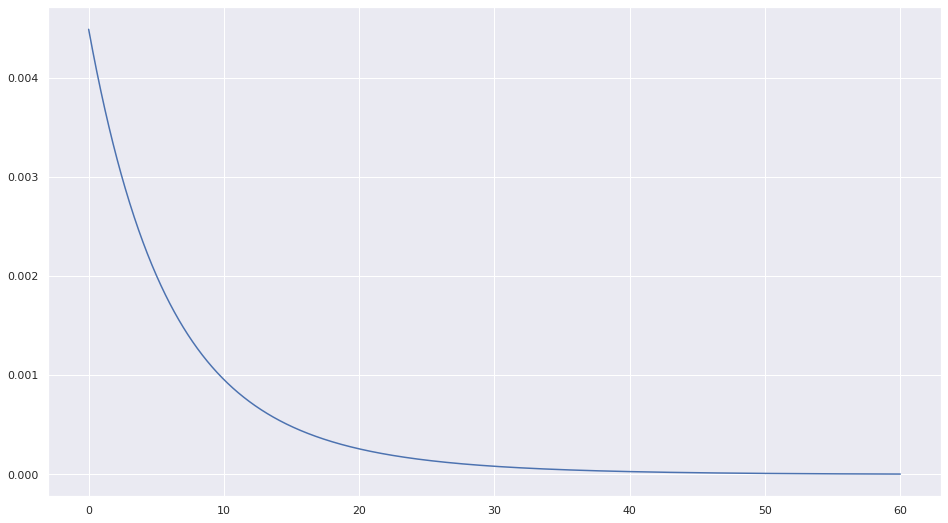

In [19]:
busses = {1 / 5: .5, 1 / 10: 0.5}

metapmf = thinkbayes2.Pmf()
for lam, prob in busses.items():
    pmf = thinkbayes2.MakeExponentialPmf(lam, high=60, n=2001)
    metapmf.Set(pmf, prob)
    
mixture = thinkbayes2.MakeMixture(metapmf)

sns.lineplot(*zip(*mixture.SortedItems()))

# Exercise 7.2

We are looking for the posterior distribution:

$ P( D | H) = \frac { P( D | H ) P(H) } { P(D) } $


In that case $H$ is the amount of time $t$ since the last bus arrived.

So the prior for the waiting time is:

$ P(H = t) = \lambda_b  \exp( - \lambda_b t ) $

where $ \lambda_b $ is the bus arrival rate within one minute.

Now we need to compute:

$ P(D | H )$ 

$ D $ in this case is the number of passengers waiting for the bus (customers) $C $ equals $ 3 $. And implicitly we also know that the bus did not come for $H=t$ minutes. So the waiting time $ W > t $

$ P(D | H ) = P(C = 3 | H=t)  P(W > t | H = t)$ 

We can multiply the two probabilities as the passengers arriving at the station and the bus arriving are assumed to be independent here. We assumed that both a uniform arrival rate.
The the likelyhood of observing 3 waiting passengers is:

$ P(D | H ) = \frac {(\lambda_p * t)^3} {3!} \exp( \lambda_p t ) \cdot   \exp( - \lambda_b t ) $ 

where $\lambda_b $ should be the arrival rate for the bus to come.

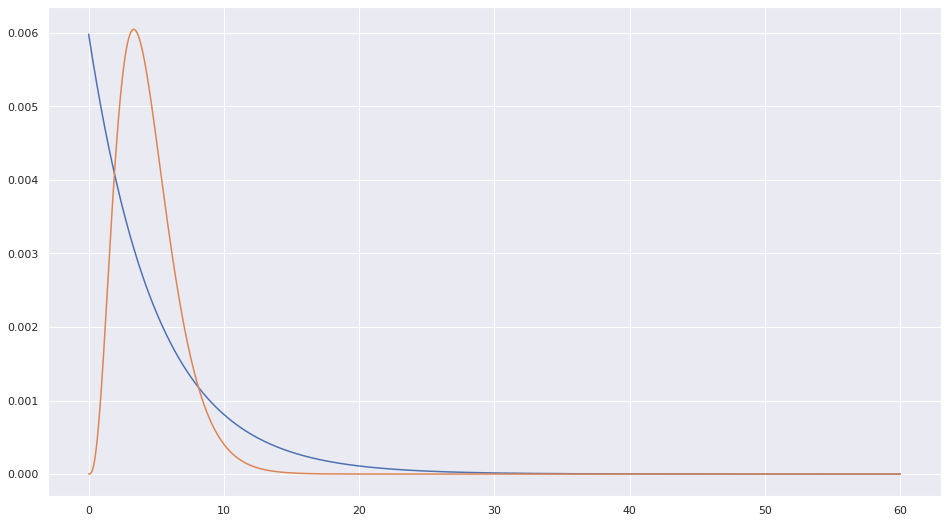

In [44]:
import math

class BusWaitingTime(thinkbayes2.Suite):
    def __init__(self, bus_rate, passenger_rate):
        super().__init__()
        for hypo, prob in thinkbayes2.MakeExponentialPmf(bus_rate, high=60, n=2001).SortedItems():
            self.Set(hypo, prob)
        self.Normalize()

        self.bus_rate = bus_rate
        self.passenger_rate = passenger_rate    
        
    def Likelihood(self, data, hypo):
        passenger_prob = (self.passenger_rate * hypo) ** data / math.factorial(data) * math.exp(self.passenger_rate * hypo)
        bus_prob = math.exp(-1. * hypo * self.bus_rate)
        return thinkbayes2.EvalPoissonPmf(data, hypo * self.passenger_rate) * bus_prob
    

bob_bus = BusWaitingTime(1 / 5, 1 / 2)

sns.lineplot(*zip(*bob_bus.SortedItems()))

bob_bus.Update(3)
sns.lineplot(*zip(*bob_bus.SortedItems()))

# Exercise 7.3

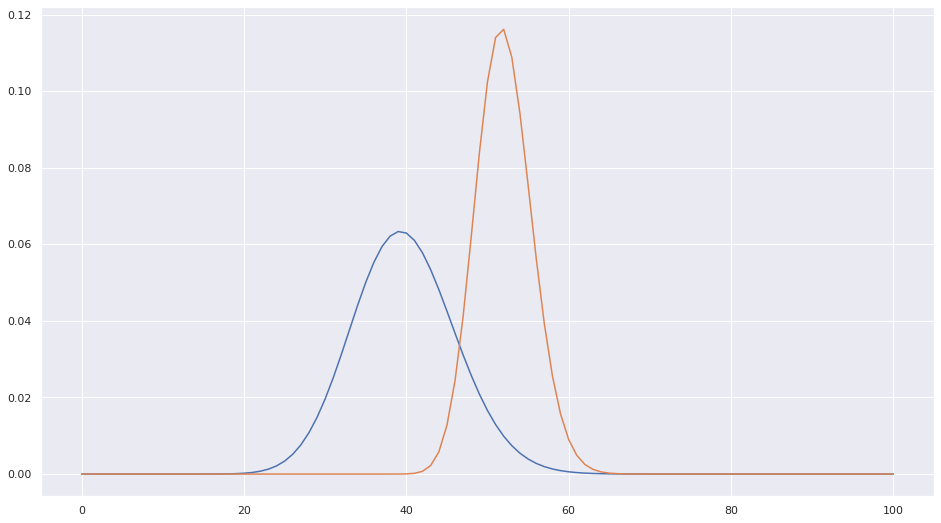

In [49]:
class CatchingFlies(thinkbayes2.Suite):
    def __init__(self, fly_rate, num_traps=100):
        super().__init__(self)
        for hypo in range(num_traps + 1):
            self.Set(
                hypo,
                sum([
                    (
                        thinkbayes2.EvalPoissonPmf(num_first_interval, fly_rate)
                        * thinkbayes2.EvalPoissonPmf(hypo - num_first_interval, fly_rate)
                        * (num_traps - num_first_interval) / num_traps
                    )
                    for num_first_interval in range(hypo + 1)
                ])
            )
        self.Normalize()
        
        self.fly_rate = fly_rate
        self.num_traps = num_traps
    
    def Likelihood(self, data, hypo):
        if hypo < data:
            prob = 0.
        else:
            prob = (
                thinkbayes2.EvalPoissonPmf(data, self.fly_rate)
                * thinkbayes2.EvalPoissonPmf(hypo - data, self.fly_rate)
                * (self.num_traps - data) / self.num_traps
            )
        return prob

catching_flies = CatchingFlies(20)
sns.lineplot(*zip(*catching_flies.SortedItems()))

catching_flies.Update(37)
sns.lineplot(*zip(*catching_flies.SortedItems()))
